# Self-Driving Car Engineer Nanodegree


## Project 1 : **Finding Lane Lines on the Road** 
***

## a) Pipeline:

    1) Read/Upload the image to be processed.
    2) Conversion into Gray Scale (cv library).
    3) Canny Edge detection in order to higlight edges.
    4) Define a polynomial region of interest (where to find lane lines).
    5) Hough Transformation in order to identify points building a line.
    6) Line drawing
    7) Overlay of the two images (lines detected + original image).
    8) Output testing.

## 0) Setting and methods definition

In [340]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import imageio
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

import math

def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def gaussian_blur(image, kernel_size=5): 
    # Define a kernel size and apply Gaussian smoothing
    blur_gray = cv2.GaussianBlur(image,(kernel_size, kernel_size),0)
    return blur_gray
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def region_of_interest(edges_image):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon"""
    
    # Create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges_image)   
    ignore_mask_color = 255   

    # Four sided polygon to mask
    imshape = edges_image.shape
    x_ROI = 450
    y_ROI = 300
    vertices = np.array([[(0,imshape[0]),(x_ROI, y_ROI), (x_ROI, y_ROI), (imshape[1],imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges_image, mask)
    return masked_edges


def hough_transformation(masked_edges):
    """Applies the Hough transformation"""
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 45  #minimum number of pixels making up a line
    max_line_gap = 20    # maximum gap in pixels between connectable line segments

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    hough_lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)
    return hough_lines

def draw_lines(original_image, image, hough_lines, color=[255, 0, 0], thickness=2):
    
    # Creating a blank to draw lines on
    line_image = np.copy(original_image)*0 
    
    # Iterate over the output "lines" and draw lines on the blank
    for line in hough_lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
        
    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((image, image, image)) 

    # Draw the lines on the edge image
    lines_drawn = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0)
    
    return lines_drawn

def mean(list):
    """
    calculate mean of list
    """
    return float(sum(list)) / max(len(list), 1)

def line_interpolation(lines):
    
    # Initialize lists to hold line formula values
    # y = mx + q
    left_line_q  = []  # q of left lines
    right_line_q = []  # q of Right lines
    left_line_m  = []  # m of Left lines
    right_line_m = []  # m of Right lines
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            
            # Slope and intersection point
            m = (y2-y1)/(x2-x1)
            q = y1 - x1*m
                
            # Seperate positive line and negative line slopes
            if m > 0:
                left_line_q.append(q)
                left_line_m.append(m)
            else:
                right_line_q.append(q)
                right_line_m.append(m)

    # Get the mean of all the lines values
    left_line_q_mean  = mean(left_line_q)
    right_line_q_mean = mean(right_line_q)
    left_line_m_mean  = mean(left_line_m)
    right_line_m_mean = mean(right_line_m)
    
    # Draw  endpoints
    
    imshape = starting_image.shape
    y_ROI_min = 325
    y_ROI_max = imshape[0]
    
    if left_line_m_mean != 0:
        x1_Left = (y_ROI_max - left_line_q_mean)/left_line_m_mean
        y1_Left = y_ROI_max
        x2_Left = (y_ROI_min - left_line_q_mean)/left_line_m_mean
        y2_Left = y_ROI_min
    if right_line_m_mean != 0:
        x1_Right = (y_ROI_max - right_line_q_mean)/right_line_m_mean
        y1_Right = y_ROI_max
        x2_Right = (y_ROI_min - right_line_q_mean)/right_line_m_mean
        y2_Right = y_ROI_min
        
    # Create a new image black image to draw lines on
    lane_img = np.zeros((starting_image.shape[0], starting_image.shape[1], 3), dtype=np.uint8)

    # Define average left and right lines
    cv2.line(lane_img, (int(x1_Left), int(y1_Left)), (int(x2_Left), int(y2_Left)), (255,50,50),11) #avg Left Line
    cv2.line(lane_img, (int(x1_Right), int(y1_Right)), (int(x2_Right), int(y2_Right)), (255,50,50),11) #avg Right .01,0.01)

    return lane_img

def overlay_images(starting_image, image_line, α=0.8, β=1., γ=0.):
    
    #Overlay the two images
    output_image = cv2.addWeighted(starting_image, 1.0, image_line, 0.50, 0.0)
    return output_image

def image_pipeline(starting_image):
    
    #Image processing pipeline
    gray_starting_image = grayscale(starting_image)
    blur_gray = gaussian_blur(gray_starting_image, kernel_size)
    edges_image = canny(blur_gray, low_threshold, high_threshold)
    masked_edges = region_of_interest(edges_image)
    hough_lines = hough_transformation(masked_edges)
    image_line = line_interpolation(hough_lines)
    image_line = line_interpolation(hough_lines)
    output_image = overlay_images(starting_image, image_line)
    return output_image
    

## 1) Read in an Image

Read an image containing white lines.

This image is: Starting image


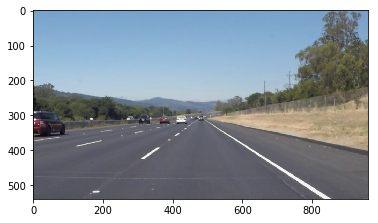

In [341]:
#reading in an image
starting_image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is: Starting image')
plt.imshow(starting_image)

## 2) Conversion into Gray Scale (cv library).

Convert a colored image into a gray one

This image is: Gray image


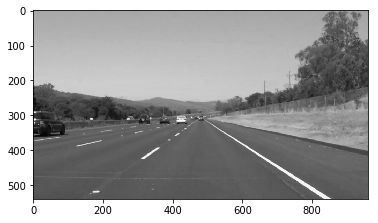

In [342]:

starting_image = cv2.imread('test_images/solidWhiteRight.jpg')
gray_starting_image = grayscale(starting_image)
print('This image is: Gray image')
plt.imshow(gray_starting_image, cmap='gray')

## 3) Canny Edge detection in order to higlight edges.

Find the line boundaries.

This image is: Edge detected


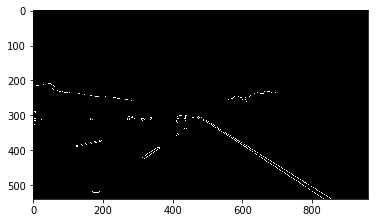

In [343]:
#Gaussian smoothing
kernel_size = 5
blur_gray = gaussian_blur(gray_starting_image, kernel_size)

#Canny edge detection
low_threshold = 100
high_threshold = 300
edges_image = canny(blur_gray, low_threshold, high_threshold)
print('This image is: Edge detected')
plt.imshow(edges_image, cmap='gray')

## 4) Define a polynomial region of interest (where to find lane lines).

Mask the image higlighting the region of interest.

This image is: Edge masked


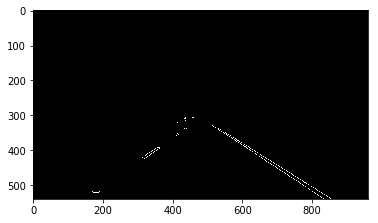

In [344]:
masked_edges = region_of_interest(edges_image)

#Print the image
print('This image is: Edge masked')
plt.imshow(masked_edges, cmap='gray')

## 5) Hough Transformation in order to identify points building a line.

Apply Hough transformation in order to create the line connecting all the line pixel

This image is: Hough Transformed with line


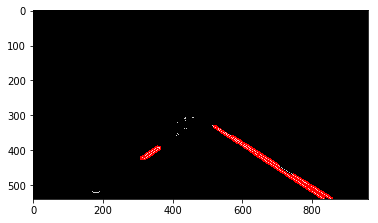

In [345]:
hough_lines = hough_transformation(masked_edges)

hough_transformed = draw_lines(starting_image, masked_edges, hough_lines)

#Print the image
print('This image is: Hough Transformed with line')
plt.imshow(hough_transformed, cmap='gray')

## 6) Line drawing

Average/extrapolate the line segments detected to map out the fullextent of the lane

This image is: Lines drawn


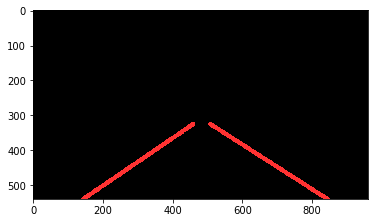

In [346]:
image_line = line_interpolation(hough_lines)

#Print the image
print('This image is: Lines drawn')
plt.imshow(image_line)

## 7) Overlay of the two images (lines detected + original image)

Average/extrapolate the line segments detected to map out the fullextent of the lane

This image is: Lines drawn


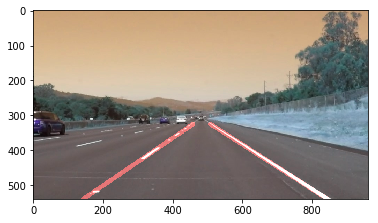

In [347]:
# overlay the empty image with the lines unto the original image with some alpha transparency

output_image = image_pipeline(starting_image)

#Print the image
print('This image is: Lines drawn')
plt.imshow(output_image)

## 8) Output testing

##    a) White Right

In [349]:
white_output = 'output_videos/white.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(image_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/white.mp4
[MoviePy] Writing video output_videos/white.mp4


  0%|          | 0/222 [00:00<?, ?it/s]


OSError: [Errno 32] Broken pipe

MoviePy error: FFMPEG encountered the following error while writing file output_videos/white.mp4:

 b'output_videos/white.mp4: No such file or directory\n'

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('./output_videos/white_output.mp4'))

##    b) Yellow Left

In [ ]:
yellow_output = 'output_videos/yellow.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(image_pipeline)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('./output_videos/yellow_output.mp4'))

##    c) Challange

In [ ]:
challenge_output = 'output_videos/extra.mp4'
clip2 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip2.fl_image(image_pipeline)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('./output_videos/challenge_output.mp4'))